In [18]:
import pandas as pd
import causallearn
from causallearn.search.ConstraintBased.PC import pc
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from causallearn.utils.cit import CIT
from causallearn.graph.Node import Node
from causallearn.graph.Graph import Graph
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from causallearn.utils.GraphUtils import GraphUtils
from tqdm import tqdm
import seaborn as sns
import matplotlib.patches as mpatches

In [19]:
final_df_all_years_df = pd.read_csv('final_df_all_years.csv')


In [20]:
df = final_df_all_years_df.copy()
variables = [
    "smoking_status",                    # current smoking status
    "RIDAGEYR", "RIAGENDR", "RIDRETH1", "INDHHIN2", "BMXBMI",   # confounders
    "MCQ160O", # COPD
    "MCQ160K", # chronic bronchitis
    "MCQ160E", # heart attack
    "MCQ160C", # coronary heart disease
    "MCQ160B", # congestive heart failure
    "MCQ160F", # stroke
    "MCQ220",  # cancer
    "MCQ160M", # thyroid problem
    "MCQ010",  # asthma
]

df = df[variables].dropna().reset_index(drop=True)
categorical_cols = ["smoking_status", "RIAGENDR", "RIDRETH1", "INDHHIN2",
                    "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", "MCQ160B", 
                    "MCQ160F", "MCQ220", "MCQ160M", "MCQ010"]

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

data_np = df.values

# PC algorithm, bootstrapping, chi square with a = 0.1, SHD, background constraints 

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge


df = final_df_all_years_df.copy()

df.rename(columns={
    "RIDAGEYR":"age",
    "RIAGENDR":"gender",
    "RIDRETH1":"ethnicity",
    "INDHHIN2":"income",
    "BMXBMI":"BMI"
}, inplace=True)

variables = [
    "smoking_status",
    "age","gender","ethnicity","income","BMI",
    "MCQ160O","MCQ160K","MCQ160E","MCQ160C",
    "MCQ160B","MCQ160F","MCQ220","MCQ160M","MCQ010"
]

df = df[variables].dropna().reset_index(drop=True)
categorical_cols = [
    "smoking_status","gender","ethnicity","income",
    "MCQ160O","MCQ160K","MCQ160E","MCQ160C","MCQ160B",
    "MCQ160F","MCQ220","MCQ160M","MCQ010"
]

encoding_maps = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoding_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    reverse_maps = {
    col: {v: k for k, v in encoding_maps[col].items()}
    for col in encoding_maps
}
    
colnames = df.columns.tolist()
p = len(colnames)

bk = BackgroundKnowledge()

diseases = [
    "MCQ160O","MCQ160K","MCQ160E","MCQ160C",
    "MCQ160B","MCQ160F","MCQ220","MCQ160M","MCQ010"
]

root_vars = ["age", "gender", "ethnicity", "income"]

def extract_adj_matrix(pc_result):
    G = pc_result.G
    if hasattr(G, "graph"):
        return G.graph.astype(int)
    if hasattr(G, "to_amat"):
        return np.array(G.to_amat(), dtype=int)
    raise RuntimeError("Cannot extract adjacency matrix from PC result.")

def pair_key(i, j):
    return tuple(sorted((i, j)))

def compute_smoking_shd(A, B, colnames, smoking_node="smoking_status"):
    """SHD only for edges involving smoking_status."""
    p = len(colnames)
    shd = 0
    smoke_idx = colnames.index(smoking_node)
    
    for i in range(p):
        for j in range(i+1, p):
            if i != smoke_idx and j != smoke_idx:
                continue
            a_ij, a_ji = A[i,j], A[j,i]
            b_ij, b_ji = B[i,j], B[j,i]
            
            presentA = a_ij or a_ji
            presentB = b_ij or b_ji
            
            if presentA != presentB:
                shd += 1
            elif presentA and presentB:
                if (a_ij - a_ji) != (b_ij - b_ji):
                    shd += 1
    return shd

alpha = 0.10
indep_test_type = "chi_square"

print("\nRunning baseline PC...")
pc_base = pc(
    df.values,
    alpha=alpha,
    labels=colnames,
    indep_test_type=indep_test_type,
    background_knowledge=bk
)

A_base = extract_adj_matrix(pc_base)

n_bootstraps = 30
edge_count = {pair_key(i,j): 0 for i in range(p) for j in range(i+1, p)}
orient_count = {pair_key(i,j): [0,0,0] for i in range(p) for j in range(i+1, p)}
shd_list = []

rng = np.random.default_rng(seed=42)

print("\nBootstrapping...")
for b in tqdm(range(n_bootstraps)):
    idx = rng.integers(0, len(df), len(df))
    sample = df.iloc[idx].values

    try:
        res = pc(
            sample,
            alpha=alpha,
            labels=colnames,
            indep_test_type=indep_test_type,
            background_knowledge=bk
        )
    except:
        continue

    A = extract_adj_matrix(res)

    for i in range(p):
        for j in range(i+1, p):
            ij, ji = A[i,j], A[j,i]
            if ij or ji:
                edge_count[(i,j)] += 1
            if ij and not ji:
                orient_count[(i,j)][0] += 1
            elif ji and not ij:
                orient_count[(i,j)][1] += 1
            elif ij and ji:
                orient_count[(i,j)][2] += 1

    shd_list.append(compute_smoking_shd(A_base, A, colnames))

rows = []
for (i,j), ec in edge_count.items():
    i_to_j, j_to_i, undir = orient_count[(i,j)]
    rows.append({
        "var_i": colnames[i],
        "var_j": colnames[j],
        "edge_freq": ec / n_bootstraps,
        "i->j_freq": i_to_j / n_bootstraps,
        "j->i_freq": j_to_i / n_bootstraps,
        "undirected_freq": undir / n_bootstraps,
        "direction_certainty": max(i_to_j, j_to_i) / n_bootstraps
    })

stab_df = pd.DataFrame(rows)

relevant_nodes = ["BMI"] + diseases + root_vars

stab_df = stab_df[
    ((stab_df["var_i"] == "smoking_status") & (stab_df["var_j"].isin(relevant_nodes))) |
    ((stab_df["var_j"] == "smoking_status") & (stab_df["var_i"].isin(relevant_nodes)))
].sort_values("edge_freq", ascending=False)

friendly_labels = {
    "smoking_status": "Smoking Status",
    "BMI": "BMI",
    "MCQ160O": "COPD",
    "MCQ160K": "Chronic Bronchitis",
    "MCQ160E": "Heart Attack",
    "MCQ160C": "Coronary Heart Disease",
    "MCQ160B": "Congestive Heart Failure",
    "MCQ160F": "Stroke",
    "MCQ220": "Cancer / Malignancy",
    "MCQ160M": "Thyroid Problem",
    "MCQ010": "Asthma",
    "age": "Age",
    "gender": "Gender",
    "ethnicity": "Ethnicity",
    "income": "Income"
}

stab_df_plot = stab_df.copy()
stab_df_plot["var_i"] = stab_df_plot["var_i"].map(friendly_labels)
stab_df_plot["var_j"] = stab_df_plot["var_j"].map(friendly_labels)
stab_baseline_edges = stab_df_plot.copy()
stab_baseline_edges['edge_label'] = stab_baseline_edges.apply(
    lambda row: f"{row['var_i']} — {row['var_j']}", axis=1
)

print("SHD = Structural Hamming Distance between the baseline adjacency matrix and a bootstrap adjacency matrix.")
print("\nMean SHD (smoking edges):", np.mean(shd_list))
print("Median SHD (smoking edges):", np.median(shd_list))
print("SHD range:", min(shd_list), "to", max(shd_list))
print("\nFiltered Stability Table (Smoking → other):")
print(stab_df_plot)

baseline_edge_freq = dict(zip(
    stab_df["var_i"] + "--" + stab_df["var_j"],
    stab_df["edge_freq"]
))

Data ready: 26732 rows × 15 variables.

Running baseline PC...


  0%|          | 0/15 [00:00<?, ?it/s]


Bootstrapping...


  0%|                                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  3%|█▍                                          | 1/30 [00:01<00:45,  1.58s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|██▉                                         | 2/30 [00:03<00:46,  1.65s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 10%|████▍                                       | 3/30 [00:04<00:42,  1.56s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█████▊                                      | 4/30 [00:06<00:44,  1.72s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 17%|███████▎                                    | 5/30 [00:08<00:43,  1.75s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|████████▊                                   | 6/30 [00:10<00:44,  1.87s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 23%|██████████▎                                 | 7/30 [00:11<00:39,  1.71s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|███████████▋                                | 8/30 [00:13<00:37,  1.71s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 30%|█████████████▏                              | 9/30 [00:16<00:40,  1.92s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|██████████████▎                            | 10/30 [00:18<00:40,  2.04s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 37%|███████████████▊                           | 11/30 [00:20<00:36,  1.93s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 40%|█████████████████▏                         | 12/30 [00:21<00:33,  1.87s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 43%|██████████████████▋                        | 13/30 [00:23<00:29,  1.71s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 47%|████████████████████                       | 14/30 [00:24<00:27,  1.73s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 50%|█████████████████████▌                     | 15/30 [00:26<00:25,  1.68s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 53%|██████████████████████▉                    | 16/30 [00:28<00:24,  1.76s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 57%|████████████████████████▎                  | 17/30 [00:30<00:25,  1.94s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 60%|█████████████████████████▊                 | 18/30 [00:32<00:21,  1.76s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 63%|███████████████████████████▏               | 19/30 [00:33<00:18,  1.66s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 67%|████████████████████████████▋              | 20/30 [00:34<00:15,  1.59s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 70%|██████████████████████████████             | 21/30 [00:36<00:15,  1.71s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 73%|███████████████████████████████▌           | 22/30 [00:38<00:13,  1.68s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 77%|████████████████████████████████▉          | 23/30 [00:40<00:11,  1.66s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 80%|██████████████████████████████████▍        | 24/30 [00:41<00:09,  1.54s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 83%|███████████████████████████████████▊       | 25/30 [00:43<00:08,  1.72s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 87%|█████████████████████████████████████▎     | 26/30 [00:45<00:06,  1.69s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 90%|██████████████████████████████████████▋    | 27/30 [00:46<00:04,  1.57s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 93%|████████████████████████████████████████▏  | 28/30 [00:48<00:03,  1.77s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████▌ | 29/30 [00:50<00:01,  1.66s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 30/30 [00:51<00:00,  1.73s/it]

SHD = Structural Hamming Distance between the baseline adjacency matrix and a bootstrap adjacency matrix.

Mean SHD (smoking edges): 0.9333333333333333
Median SHD (smoking edges): 1.0
SHD range: 0 to 2

Filtered Stability Table (Smoking → other):
             var_i                     var_j  edge_freq  i->j_freq  j->i_freq  \
1   Smoking Status                    Gender   1.000000        0.0        0.0   
3   Smoking Status                    Income   1.000000        0.0        0.0   
4   Smoking Status                       BMI   1.000000        0.0        0.0   
6   Smoking Status        Chronic Bronchitis   1.000000        0.0        0.0   
7   Smoking Status              Heart Attack   1.000000        0.0        0.0   
10  Smoking Status                    Stroke   1.000000        0.0        0.0   
13  Smoking Status                    Asthma   1.000000        0.0        0.0   
5   Smoking Status                      COPD   0.966667        0.0        0.0   
11  Smoking Status      

# PC Edge Frequency for Edges Involving Smoking Status

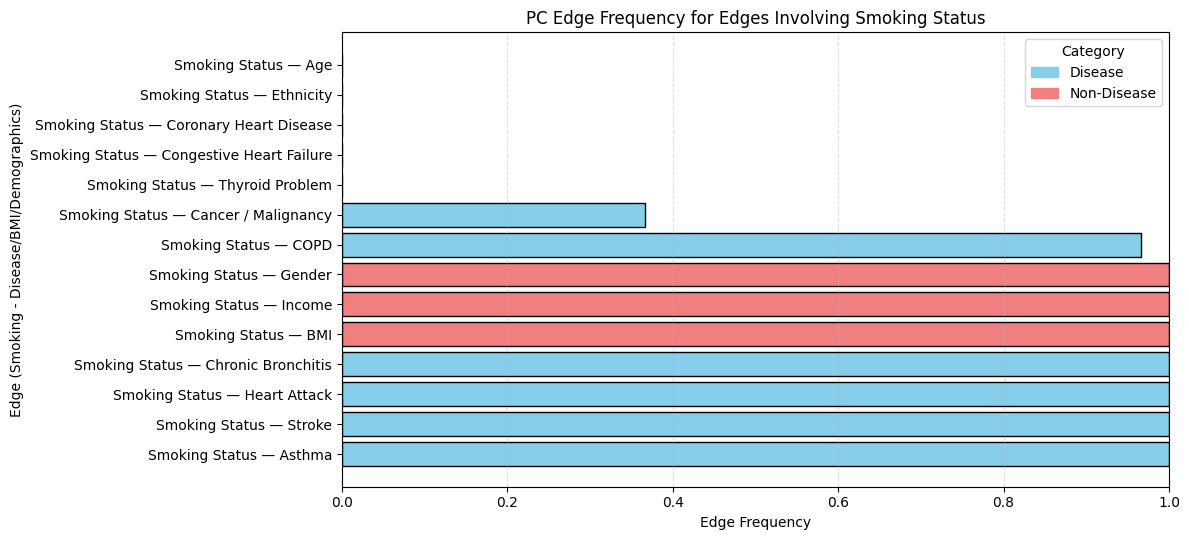

In [6]:
edges_of_interest = ["BMI","MCQ160O","MCQ160K","MCQ160E","MCQ160C",
                     "MCQ160B","MCQ160F","MCQ220","MCQ160M","MCQ010"]

demographics = ["age","gender","ethnicity", "income"]
edges_of_interest += demographics
disease_variables = [
    "MCQ160O", "MCQ160K", "MCQ160E", "MCQ160C", 
    "MCQ160B", "MCQ160F", "MCQ220", "MCQ160M", "MCQ010"
]

non_disease_variables = ["age", "gender", "ethnicity", "income", "BMI"]
friendly_to_original = {friendly_labels[k]: k for k in friendly_labels}
def classify_edge(row):
    other = row['var_j'] if row['var_i'] == "Smoking Status" else row['var_i']
    original_name = friendly_to_original.get(other, other)

    if original_name in disease_variables:
        return "Disease"
    else:
        return "Non-Disease"

stab_baseline_edges['category'] = stab_baseline_edges.apply(classify_edge, axis=1)


color_map = {
    "Disease": "lightcoral", 
    "Non-Disease": "skyblue"
}

stab_baseline_edges['color'] = stab_baseline_edges['category'].map(color_map)
plot_df = stab_baseline_edges.sort_values('edge_freq', ascending=True).reset_index(drop=True)
y_pos = np.arange(len(plot_df))
colors = plot_df['color'].tolist()
edgecolor = 'black'
plt.figure(figsize=(12,5.5), dpi = 100)

plt.barh(
    y=y_pos,
    width=plot_df['edge_freq'],
    color=colors,
    edgecolor=edgecolor
)

plt.yticks(y_pos, plot_df['edge_label'])
plt.gca().invert_yaxis()

plt.xlabel("Edge Frequency")
plt.ylabel("Edge (Smoking - Disease/BMI/Demographics)")
plt.title("PC Edge Frequency for Edges Involving Smoking Status")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.4)
handles = [mpatches.Patch(color=color, label=cat) for cat, color in color_map.items()]
plt.legend(handles=handles, title="Category", loc="upper right")
plt.tight_layout()
plt.show()

# Demographic Analysis Function

In [7]:
friendly_labels = {
    "smoking_status": "Smoking Status",
    "BMI": "BMI",
    "MCQ160O": "COPD",
    "MCQ160K": "Chronic Bronchitis",
    "MCQ160E": "Heart Attack",
    "MCQ160C": "Coronary Heart Disease",
    "MCQ160B": "Congestive Heart Failure",
    "MCQ160F": "Stroke",
    "MCQ220": "Cancer / Malignancy",
    "MCQ160M": "Thyroid Problem",
    "MCQ010": "Asthma",
    "age": "Age",
    "gender": "Gender",
    "ethnicity": "Ethnicity",
    "income": "Income"
}

human_readable_maps = {
    "age_group": {
        0: "10-19", 1: "20-29", 2: "30-39", 3: "40-49",
        4: "50-59", 5: "60-69", 6: "70-79", 7: "80-89"
    },
    "gender": {0: "Male", 1: "Female"},
    "ethnicity": {
        0: "Mexican American",
        1: "Other Hispanic",
        2: "Non-Hispanic White",
        3: "Non-Hispanic Black",
        4: "Other / Multi-Racial"
    }
}


def run_pc_subgroup_analysis(df, demographic_col, encoding_maps, baseline_edge_freq, colnames, bk, amat_baseline,
                             n_bootstraps=30, alpha=0.1, indep_test_type="chi_square", human_readable_map=None):
    """
    Runs PC bootstrapping for a given demographic column and returns:
    - Edge frequency matrix (rows = smoking edges, columns = subgroups) → for Heatmap (Vis 2)
    - SD within subgroups and vs baseline → for Barplots (Vis 4)
    """

    print(f"\n===== Running PC Subgroup Analysis for {demographic_col} =====")

    subgroup_label_map = {v: k for k, v in encoding_maps[demographic_col].items()}
    subgroup_values = df[demographic_col].unique()
    subgroup_results = {}
    demographics = ["age", "gender", "ethnicity", "income"]
    
    edges_of_interest = ["BMI"] + [
        "MCQ160O","MCQ160K","MCQ160E","MCQ160C","MCQ160B",
        "MCQ160F","MCQ220","MCQ160M","MCQ010"
    ] + demographics

    for subgroup in subgroup_values:
        print(f"\nSubgroup: {subgroup} ({demographic_col})")

        df_sub = df[df[demographic_col] == subgroup].reset_index(drop=True)
        n_sub = len(df_sub)
        print(f"Subgroup size: {n_sub} rows")
        p = len(colnames)
        edge_count = {pair_key(i,j): 0 for i in range(p) for j in range(i+1,p)}
        orient_count = {pair_key(i,j): [0,0,0] for i in range(p) for j in range(i+1,p)}
        shd_list = []

        rng = np.random.default_rng(seed=42)

        for b in tqdm(range(n_bootstraps), desc=f"Bootstraps ({subgroup})"):
            idx = rng.integers(0, n_sub, n_sub)
            sample = df_sub.iloc[idx].values

            try:
                res = pc(
                    sample,
                    alpha=alpha,
                    labels=colnames,
                    indep_test_type=indep_test_type,
                    background_knowledge=bk
                )
            except Exception as e:
                print(f"PC failed on bootstrap {b}: {e}")
                continue

            amat = extract_adj_matrix(res)

            for i in range(p):
                for j in range(i+1, p):
                    a_ij, a_ji = amat[i,j], amat[j,i]
                    if a_ij or a_ji:
                        edge_count[(i,j)] += 1
                    if a_ij and not a_ji:
                        orient_count[(i,j)][0] += 1
                    elif a_ji and not a_ij:
                        orient_count[(i,j)][1] += 1
                    elif a_ij and a_ji:
                        orient_count[(i,j)][2] += 1

            shd_list.append(compute_smoking_shd(amat_baseline, amat, colnames))

        rows = []
        for (i,j), ec in edge_count.items():
            i_to_j, j_to_i, undir = orient_count[(i,j)]
            var_i, var_j = colnames[i], colnames[j]
            if "smoking_status" not in (var_i, var_j):
                continue
            other_var = var_j if var_i == "smoking_status" else var_i
            if other_var not in edges_of_interest:
                continue

            rows.append({
                "var_i": var_i,
                "var_j": var_j,
                "edge_freq": ec / n_bootstraps,
                "i->j_freq": i_to_j / n_bootstraps,
                "j->i_freq": j_to_i / n_bootstraps,
                "undirected_freq": undir / n_bootstraps
            })

        stab_sub_df = pd.DataFrame(rows)
        print(f"Subgroup {subgroup} mean SHD: {np.mean(shd_list):.2f}, median SHD: {np.median(shd_list):.2f}")

        subgroup_results[subgroup] = {
            "stab_df": stab_sub_df,
            "shd_list": shd_list
        }
    edges_friendly = [
    f"{friendly_labels.get(row['var_i'], row['var_i'])} - {friendly_labels.get(row['var_j'], row['var_j'])}"
    for row in rows
]

    freq_matrix = pd.DataFrame(index=edges_friendly, columns=subgroup_values, dtype=float)

    for subgroup in subgroup_values:
        df_sub = subgroup_results[subgroup]["stab_df"]
        for _, row in df_sub.iterrows():
            edge_label = f"{friendly_labels.get(row['var_i'], row['var_i'])} - {friendly_labels.get(row['var_j'], row['var_j'])}"
            freq_matrix.loc[edge_label, subgroup] = row["edge_freq"]
            # edge_label = f"{row['var_i']}--{row['var_j']}"

    freq_matrix = freq_matrix.astype(float)
    row_order = freq_matrix.mean(axis=1).sort_values(ascending=False).index
    freq_matrix = freq_matrix.loc[row_order]
    subgroup_values_sorted = sorted(freq_matrix.columns)
    freq_matrix = freq_matrix[subgroup_values_sorted]
    if human_readable_map is not None:
        freq_matrix.rename(columns=human_readable_map, inplace=True)

    plt.figure(figsize=(12, 0.5*len(freq_matrix)))
    sns.heatmap(freq_matrix, cmap="Blues", vmin=0, vmax=1, annot=True, fmt=".2f")
    plt.title(f"Smoking - Outcome Edge Frequency Across {demographic_col} Subgroups")
    plt.xlabel("Subgroup")
    plt.ylabel("Edge")
    plt.show()

    return subgroup_results, freq_matrix

# Ethnicity Demographic Analysis

In [8]:
demographic_col = "ethnicity"
n_bootstraps = 30
alpha = 0.1
indep_test_type = "chi_square"
amat_baseline = A_base
subgroup_results_ethnicity, _,  = run_pc_subgroup_analysis(
    df=df,
    demographic_col=demographic_col,
    encoding_maps=encoding_maps,
    baseline_edge_freq = baseline_edge_freq,
    colnames=colnames,
    bk=bk,
    amat_baseline=amat_baseline,
    n_bootstraps=n_bootstraps,
    alpha=alpha,
    indep_test_type=indep_test_type,
    human_readable_map=human_readable_maps['ethnicity']
)


===== Running PC Subgroup Analysis for ethnicity =====

Subgroup: 2 (ethnicity)
Subgroup size: 10563 rows


Bootstraps (2):   0%|                                    | 0/30 [00:00<?, ?it/s]/opt/anaconda3/envs/causal-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/causal-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):   3%|▉                           | 1/30 [00:04<02:03,  4.25s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):   7%|█▊                          | 2/30 [00:08<02:00,  4.32s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  10%|██▊                         | 3/30 [00:12<01:56,  4.33s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  13%|███▋                        | 4/30 [00:17<01:49,  4.22s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  17%|████▋                       | 5/30 [00:21<01:47,  4.28s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  20%|█████▌                      | 6/30 [00:25<01:44,  4.35s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  23%|██████▌                     | 7/30 [00:30<01:44,  4.52s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  27%|███████▍                    | 8/30 [00:35<01:41,  4.62s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  30%|████████▍                   | 9/30 [00:40<01:39,  4.72s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  33%|█████████                  | 10/30 [00:45<01:36,  4.83s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  37%|█████████▉                 | 11/30 [00:49<01:28,  4.66s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  40%|██████████▊                | 12/30 [00:54<01:23,  4.65s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  43%|███████████▋               | 13/30 [00:58<01:16,  4.51s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  47%|████████████▌              | 14/30 [01:03<01:11,  4.49s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  50%|█████████████▌             | 15/30 [01:08<01:09,  4.60s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  53%|██████████████▍            | 16/30 [01:12<01:03,  4.54s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  57%|███████████████▎           | 17/30 [01:17<01:00,  4.62s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  60%|████████████████▏          | 18/30 [01:21<00:55,  4.62s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  63%|█████████████████          | 19/30 [01:26<00:50,  4.58s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  67%|██████████████████         | 20/30 [01:30<00:45,  4.53s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  70%|██████████████████▉        | 21/30 [01:34<00:39,  4.37s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  73%|███████████████████▊       | 22/30 [01:38<00:34,  4.30s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  77%|████████████████████▋      | 23/30 [01:43<00:30,  4.29s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  80%|█████████████████████▌     | 24/30 [01:47<00:25,  4.31s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  83%|██████████████████████▌    | 25/30 [01:51<00:21,  4.32s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  87%|███████████████████████▍   | 26/30 [01:56<00:17,  4.36s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  90%|████████████████████████▎  | 27/30 [02:00<00:12,  4.28s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  93%|█████████████████████████▏ | 28/30 [02:04<00:08,  4.29s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2):  97%|██████████████████████████ | 29/30 [02:09<00:04,  4.35s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (2): 100%|███████████████████████████| 30/30 [02:13<00:00,  4.45s/it]


Subgroup 2 mean SHD: 5.13, median SHD: 5.00

Subgroup: 3 (ethnicity)
Subgroup size: 5797 rows


Bootstraps (3):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):   3%|▉                           | 1/30 [00:04<01:57,  4.07s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):   7%|█▊                          | 2/30 [00:08<01:55,  4.13s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  10%|██▊                         | 3/30 [00:12<01:49,  4.04s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  13%|███▋                        | 4/30 [00:16<01:46,  4.09s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  17%|████▋                       | 5/30 [00:20<01:43,  4.13s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  20%|█████▌                      | 6/30 [00:24<01:37,  4.07s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  23%|██████▌                     | 7/30 [00:28<01:32,  4.04s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  27%|███████▍                    | 8/30 [00:32<01:27,  3.98s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  30%|████████▍                   | 9/30 [00:36<01:23,  3.97s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  33%|█████████                  | 10/30 [00:40<01:18,  3.93s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  37%|█████████▉                 | 11/30 [00:44<01:15,  3.99s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  40%|██████████▊                | 12/30 [00:48<01:13,  4.06s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  43%|███████████▋               | 13/30 [00:52<01:08,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  47%|████████████▌              | 14/30 [00:56<01:06,  4.18s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  50%|█████████████▌             | 15/30 [01:01<01:02,  4.14s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  53%|██████████████▍            | 16/30 [01:05<00:57,  4.13s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  57%|███████████████▎           | 17/30 [01:09<00:54,  4.21s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  60%|████████████████▏          | 18/30 [01:13<00:49,  4.14s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  63%|█████████████████          | 19/30 [01:17<00:45,  4.11s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  67%|██████████████████         | 20/30 [01:21<00:40,  4.09s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  70%|██████████████████▉        | 21/30 [01:25<00:37,  4.14s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  73%|███████████████████▊       | 22/30 [01:30<00:33,  4.19s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  77%|████████████████████▋      | 23/30 [01:34<00:28,  4.12s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  80%|█████████████████████▌     | 24/30 [01:38<00:24,  4.13s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  83%|██████████████████████▌    | 25/30 [01:42<00:20,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  87%|███████████████████████▍   | 26/30 [01:46<00:16,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  90%|████████████████████████▎  | 27/30 [01:50<00:12,  4.12s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  93%|█████████████████████████▏ | 28/30 [01:54<00:08,  4.03s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3):  97%|██████████████████████████ | 29/30 [01:58<00:04,  4.04s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (3): 100%|███████████████████████████| 30/30 [02:02<00:00,  4.08s/it]


Subgroup 3 mean SHD: 4.97, median SHD: 5.00

Subgroup: 0 (ethnicity)
Subgroup size: 3873 rows


Bootstraps (0):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):   3%|▉                           | 1/30 [00:04<02:01,  4.18s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):   7%|█▊                          | 2/30 [00:08<01:57,  4.19s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  10%|██▊                         | 3/30 [00:12<01:46,  3.95s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  13%|███▋                        | 4/30 [00:16<01:42,  3.95s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  17%|████▋                       | 5/30 [00:20<01:41,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  20%|█████▌                      | 6/30 [00:24<01:35,  3.99s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  23%|██████▌                     | 7/30 [00:28<01:32,  4.02s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  27%|███████▍                    | 8/30 [00:32<01:29,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  30%|████████▍                   | 9/30 [00:36<01:26,  4.13s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  33%|█████████                  | 10/30 [00:40<01:21,  4.09s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  37%|█████████▉                 | 11/30 [00:44<01:18,  4.11s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  40%|██████████▊                | 12/30 [00:48<01:12,  4.03s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  43%|███████████▋               | 13/30 [00:52<01:07,  3.95s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  47%|████████████▌              | 14/30 [00:56<01:03,  3.95s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  50%|█████████████▌             | 15/30 [01:00<01:01,  4.10s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  53%|██████████████▍            | 16/30 [01:04<00:57,  4.10s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  57%|███████████████▎           | 17/30 [01:09<00:56,  4.38s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  60%|████████████████▏          | 18/30 [01:13<00:50,  4.23s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  63%|█████████████████          | 19/30 [01:17<00:45,  4.10s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  67%|██████████████████         | 20/30 [01:21<00:40,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  70%|██████████████████▉        | 21/30 [01:25<00:36,  4.07s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  73%|███████████████████▊       | 22/30 [01:29<00:33,  4.13s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  77%|████████████████████▋      | 23/30 [01:33<00:28,  4.01s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  80%|█████████████████████▌     | 24/30 [01:37<00:23,  3.95s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  83%|██████████████████████▌    | 25/30 [01:41<00:20,  4.12s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  87%|███████████████████████▍   | 26/30 [01:47<00:18,  4.51s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  90%|████████████████████████▎  | 27/30 [01:51<00:13,  4.43s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  93%|█████████████████████████▏ | 28/30 [01:56<00:09,  4.59s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0):  97%|██████████████████████████ | 29/30 [02:00<00:04,  4.41s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (0): 100%|███████████████████████████| 30/30 [02:14<00:00,  4.47s/it]


Subgroup 0 mean SHD: 8.37, median SHD: 8.00

Subgroup: 1 (ethnicity)
Subgroup size: 2744 rows


Bootstraps (1):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):   3%|▉                           | 1/30 [00:03<01:49,  3.79s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):   7%|█▊                          | 2/30 [00:07<01:46,  3.79s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  10%|██▊                         | 3/30 [00:11<01:40,  3.71s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  13%|███▋                        | 4/30 [00:14<01:37,  3.73s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  17%|████▋                       | 5/30 [00:18<01:33,  3.74s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  20%|█████▌                      | 6/30 [00:22<01:29,  3.75s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  23%|██████▌                     | 7/30 [00:26<01:26,  3.74s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  27%|███████▍                    | 8/30 [00:30<01:25,  3.89s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  30%|████████▍                   | 9/30 [00:34<01:22,  3.95s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  33%|█████████                  | 10/30 [00:38<01:18,  3.93s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  37%|█████████▉                 | 11/30 [00:42<01:13,  3.87s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  40%|██████████▊                | 12/30 [00:46<01:11,  3.95s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  43%|███████████▋               | 13/30 [00:50<01:06,  3.94s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  47%|████████████▌              | 14/30 [00:53<01:01,  3.85s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  50%|█████████████▌             | 15/30 [00:57<00:58,  3.92s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  53%|██████████████▍            | 16/30 [01:01<00:54,  3.86s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  57%|███████████████▎           | 17/30 [01:05<00:49,  3.82s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  60%|████████████████▏          | 18/30 [01:09<00:46,  3.84s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  63%|█████████████████          | 19/30 [01:13<00:42,  3.88s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  67%|██████████████████         | 20/30 [01:16<00:38,  3.85s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  70%|██████████████████▉        | 21/30 [01:20<00:34,  3.83s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  73%|███████████████████▊       | 22/30 [01:24<00:30,  3.82s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  77%|████████████████████▋      | 23/30 [01:28<00:26,  3.84s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  80%|█████████████████████▌     | 24/30 [01:32<00:22,  3.79s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  83%|██████████████████████▌    | 25/30 [01:35<00:18,  3.77s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  87%|███████████████████████▍   | 26/30 [01:39<00:15,  3.79s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  90%|████████████████████████▎  | 27/30 [01:43<00:11,  3.78s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  93%|█████████████████████████▏ | 28/30 [01:47<00:07,  3.78s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1):  97%|██████████████████████████ | 29/30 [01:51<00:03,  3.82s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (1): 100%|███████████████████████████| 30/30 [01:54<00:00,  3.83s/it]


Subgroup 1 mean SHD: 6.97, median SHD: 7.00

Subgroup: 4 (ethnicity)
Subgroup size: 3755 rows


Bootstraps (4):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):   3%|▉                           | 1/30 [00:03<01:49,  3.78s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):   7%|█▊                          | 2/30 [00:07<01:52,  4.02s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  10%|██▊                         | 3/30 [00:12<01:51,  4.13s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  13%|███▋                        | 4/30 [00:16<01:45,  4.08s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  17%|████▋                       | 5/30 [00:20<01:41,  4.07s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  20%|█████▌                      | 6/30 [00:24<01:36,  4.03s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  23%|██████▌                     | 7/30 [00:27<01:30,  3.93s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  27%|███████▍                    | 8/30 [00:32<01:27,  3.99s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  30%|████████▍                   | 9/30 [00:36<01:25,  4.06s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  33%|█████████                  | 10/30 [00:40<01:20,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  37%|█████████▉                 | 11/30 [00:44<01:16,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  40%|██████████▊                | 12/30 [00:48<01:12,  4.03s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  43%|███████████▋               | 13/30 [00:52<01:10,  4.12s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  47%|████████████▌              | 14/30 [00:56<01:04,  4.04s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  50%|█████████████▌             | 15/30 [01:00<00:59,  4.00s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  53%|██████████████▍            | 16/30 [01:05<00:58,  4.20s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  57%|███████████████▎           | 17/30 [01:09<00:53,  4.11s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  60%|████████████████▏          | 18/30 [01:13<00:48,  4.08s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  63%|█████████████████          | 19/30 [01:16<00:44,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  67%|██████████████████         | 20/30 [01:21<00:40,  4.06s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  70%|██████████████████▉        | 21/30 [01:25<00:36,  4.05s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  73%|███████████████████▊       | 22/30 [01:29<00:33,  4.21s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  77%|████████████████████▋      | 23/30 [01:33<00:29,  4.19s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  80%|█████████████████████▌     | 24/30 [01:38<00:25,  4.23s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  83%|██████████████████████▌    | 25/30 [01:42<00:21,  4.30s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  87%|███████████████████████▍   | 26/30 [01:46<00:16,  4.24s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  90%|████████████████████████▎  | 27/30 [01:51<00:13,  4.39s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  93%|█████████████████████████▏ | 28/30 [01:56<00:08,  4.44s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4):  97%|██████████████████████████ | 29/30 [02:00<00:04,  4.39s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

Bootstraps (4): 100%|███████████████████████████| 30/30 [02:04<00:00,  4.16s/it]


Subgroup 4 mean SHD: 5.53, median SHD: 6.00


# Age Demographic Analysis


===== Running PC Subgroup Analysis for age_group =====

Subgroup: 2 (age_group)
Subgroup size: 4505 rows


Bootstraps (2):   0%|                                    | 0/30 [00:00<?, ?it/s]/opt/anaconda3/envs/causal-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/causal-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):   3%|▉                           | 1/30 [00:08<04:19,  8.94s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):   7%|█▊                          | 2/30 [00:17<03:56,  8.46s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  10%|██▊                         | 3/30 [00:25<03:42,  8.23s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  13%|███▋                        | 4/30 [00:32<03:30,  8.09s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  17%|████▋                       | 5/30 [00:40<03:19,  7.97s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  20%|█████▌                      | 6/30 [00:48<03:14,  8.09s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  23%|██████▌                     | 7/30 [00:58<03:13,  8.43s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  27%|███████▍                    | 8/30 [01:05<03:01,  8.24s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  30%|████████▍                   | 9/30 [01:13<02:50,  8.11s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  33%|█████████                  | 10/30 [01:21<02:39,  7.96s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  37%|█████████▉                 | 11/30 [01:29<02:30,  7.95s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  40%|██████████▊                | 12/30 [01:37<02:21,  7.88s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  43%|███████████▋               | 13/30 [01:45<02:14,  7.91s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  47%|████████████▌              | 14/30 [01:52<02:05,  7.85s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  50%|█████████████▌             | 15/30 [02:00<01:56,  7.79s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  53%|██████████████▍            | 16/30 [02:08<01:49,  7.82s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  57%|███████████████▎           | 17/30 [02:16<01:41,  7.81s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  60%|████████████████▏          | 18/30 [02:23<01:33,  7.77s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  63%|█████████████████          | 19/30 [02:31<01:25,  7.78s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  67%|██████████████████         | 20/30 [02:39<01:17,  7.78s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  70%|██████████████████▉        | 21/30 [02:47<01:10,  7.79s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  73%|███████████████████▊       | 22/30 [02:54<01:02,  7.80s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  77%|████████████████████▋      | 23/30 [03:02<00:54,  7.78s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  80%|█████████████████████▌     | 24/30 [03:10<00:46,  7.79s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  83%|██████████████████████▌    | 25/30 [03:18<00:38,  7.80s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  87%|███████████████████████▍   | 26/30 [03:26<00:31,  7.80s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  90%|████████████████████████▎  | 27/30 [03:33<00:23,  7.81s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  93%|█████████████████████████▏ | 28/30 [03:43<00:16,  8.20s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2):  97%|██████████████████████████ | 29/30 [03:50<00:08,  8.10s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (2): 100%|███████████████████████████| 30/30 [03:58<00:00,  7.96s/it]


Subgroup 2 mean SHD: 5.30, median SHD: 5.50

Subgroup: 5 (age_group)
Subgroup size: 4512 rows


Bootstraps (5):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):   3%|▉                           | 1/30 [00:07<03:39,  7.57s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):   7%|█▊                          | 2/30 [00:16<03:46,  8.09s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  10%|██▊                         | 3/30 [00:24<03:45,  8.36s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  13%|███▋                        | 4/30 [00:33<03:41,  8.51s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  17%|████▋                       | 5/30 [00:41<03:32,  8.50s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  20%|█████▌                      | 6/30 [00:49<03:18,  8.27s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  23%|██████▌                     | 7/30 [00:57<03:06,  8.11s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  27%|███████▍                    | 8/30 [01:05<02:58,  8.09s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  30%|████████▍                   | 9/30 [01:13<02:47,  7.96s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  33%|█████████                  | 10/30 [01:21<02:40,  8.00s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  37%|█████████▉                 | 11/30 [01:29<02:30,  7.93s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  40%|██████████▊                | 12/30 [01:36<02:20,  7.82s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  43%|███████████▋               | 13/30 [01:44<02:12,  7.79s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  47%|████████████▌              | 14/30 [01:52<02:04,  7.75s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  50%|█████████████▌             | 15/30 [02:00<01:57,  7.83s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  53%|██████████████▍            | 16/30 [02:07<01:49,  7.79s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  57%|███████████████▎           | 17/30 [02:15<01:40,  7.72s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  60%|████████████████▏          | 18/30 [02:23<01:32,  7.71s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  63%|█████████████████          | 19/30 [02:31<01:26,  7.91s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  67%|██████████████████         | 20/30 [02:39<01:18,  7.82s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  70%|██████████████████▉        | 21/30 [02:46<01:10,  7.78s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  73%|███████████████████▊       | 22/30 [02:54<01:01,  7.75s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  77%|████████████████████▋      | 23/30 [03:02<00:54,  7.76s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  80%|█████████████████████▌     | 24/30 [03:10<00:47,  7.94s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  83%|██████████████████████▌    | 25/30 [03:18<00:39,  7.92s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  87%|███████████████████████▍   | 26/30 [03:26<00:31,  7.93s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  90%|████████████████████████▎  | 27/30 [03:34<00:23,  7.89s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  93%|█████████████████████████▏ | 28/30 [03:41<00:15,  7.81s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5):  97%|██████████████████████████ | 29/30 [03:49<00:07,  7.79s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (5): 100%|███████████████████████████| 30/30 [03:57<00:00,  7.91s/it]


Subgroup 5 mean SHD: 4.70, median SHD: 5.00

Subgroup: 1 (age_group)
Subgroup size: 4456 rows


Bootstraps (1):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):   3%|▉                           | 1/30 [00:07<03:40,  7.61s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):   7%|█▊                          | 2/30 [00:15<03:36,  7.72s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  10%|██▊                         | 3/30 [00:23<03:27,  7.67s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  13%|███▋                        | 4/30 [00:30<03:17,  7.59s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  17%|████▋                       | 5/30 [00:38<03:09,  7.57s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  20%|█████▌                      | 6/30 [00:45<03:02,  7.62s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  23%|██████▌                     | 7/30 [00:53<02:56,  7.66s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  27%|███████▍                    | 8/30 [01:01<02:48,  7.67s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  30%|████████▍                   | 9/30 [01:08<02:40,  7.66s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  33%|█████████                  | 10/30 [01:16<02:33,  7.68s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  37%|█████████▉                 | 11/30 [01:24<02:25,  7.68s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  40%|██████████▊                | 12/30 [01:31<02:17,  7.63s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  43%|███████████▋               | 13/30 [01:39<02:08,  7.55s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  47%|████████████▌              | 14/30 [01:46<02:00,  7.54s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  50%|█████████████▌             | 15/30 [01:54<01:53,  7.54s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  53%|██████████████▍            | 16/30 [02:01<01:45,  7.54s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  57%|███████████████▎           | 17/30 [02:09<01:37,  7.52s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  60%|████████████████▏          | 18/30 [02:16<01:30,  7.50s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  63%|█████████████████          | 19/30 [02:24<01:23,  7.55s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  67%|██████████████████         | 20/30 [02:31<01:15,  7.54s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  70%|██████████████████▉        | 21/30 [02:39<01:08,  7.60s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  73%|███████████████████▊       | 22/30 [02:47<01:00,  7.57s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  77%|████████████████████▋      | 23/30 [02:54<00:53,  7.60s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  80%|█████████████████████▌     | 24/30 [03:02<00:45,  7.55s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  83%|██████████████████████▌    | 25/30 [03:09<00:37,  7.55s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  87%|███████████████████████▍   | 26/30 [03:17<00:30,  7.55s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  90%|████████████████████████▎  | 27/30 [03:24<00:22,  7.57s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  93%|█████████████████████████▏ | 28/30 [03:32<00:15,  7.53s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  97%|██████████████████████████ | 29/30 [03:46<00:09,  9.65s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1): 100%|███████████████████████████| 30/30 [03:54<00:00,  7.82s/it]


Subgroup 1 mean SHD: 5.43, median SHD: 5.00

Subgroup: 3 (age_group)
Subgroup size: 4523 rows


Bootstraps (3):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):   3%|▉                           | 1/30 [00:07<03:50,  7.95s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):   7%|█▊                          | 2/30 [00:16<03:48,  8.18s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  10%|██▊                         | 3/30 [00:24<03:40,  8.16s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  13%|███▋                        | 4/30 [00:32<03:33,  8.20s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  17%|████▋                       | 5/30 [00:40<03:22,  8.09s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  20%|█████▌                      | 6/30 [00:49<03:19,  8.31s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  23%|██████▌                     | 7/30 [00:57<03:12,  8.36s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  27%|███████▍                    | 8/30 [01:06<03:04,  8.36s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  30%|████████▍                   | 9/30 [01:14<02:54,  8.30s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  33%|█████████                  | 10/30 [01:22<02:44,  8.25s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  37%|█████████▉                 | 11/30 [01:30<02:34,  8.13s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  40%|██████████▊                | 12/30 [01:38<02:25,  8.06s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  43%|███████████▋               | 13/30 [01:46<02:19,  8.19s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  47%|████████████▌              | 14/30 [01:55<02:12,  8.30s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  50%|█████████████▌             | 15/30 [02:03<02:03,  8.24s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  53%|██████████████▍            | 16/30 [02:11<01:53,  8.13s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  57%|███████████████▎           | 17/30 [02:19<01:44,  8.06s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  60%|████████████████▏          | 18/30 [02:26<01:35,  7.97s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  63%|█████████████████          | 19/30 [02:34<01:26,  7.87s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  67%|██████████████████         | 20/30 [02:42<01:18,  7.81s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  70%|██████████████████▉        | 21/30 [02:50<01:10,  7.85s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  73%|███████████████████▊       | 22/30 [02:57<01:02,  7.76s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  77%|████████████████████▋      | 23/30 [03:05<00:54,  7.81s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  80%|█████████████████████▌     | 24/30 [03:13<00:46,  7.77s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  83%|██████████████████████▌    | 25/30 [03:21<00:39,  7.80s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  87%|███████████████████████▍   | 26/30 [03:29<00:32,  8.07s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  90%|████████████████████████▎  | 27/30 [03:39<00:25,  8.39s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  93%|█████████████████████████▏ | 28/30 [03:46<00:16,  8.21s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3):  97%|██████████████████████████ | 29/30 [03:54<00:08,  8.10s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (3): 100%|███████████████████████████| 30/30 [04:03<00:00,  8.12s/it]


Subgroup 3 mean SHD: 4.13, median SHD: 4.00

Subgroup: 7 (age_group)
Subgroup size: 1662 rows


Bootstraps (7):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):   3%|▉                           | 1/30 [00:14<06:54, 14.28s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):   7%|█▊                          | 2/30 [00:28<06:33, 14.07s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  10%|██▊                         | 3/30 [00:41<06:16, 13.93s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  13%|███▋                        | 4/30 [00:55<06:02, 13.96s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  17%|████▋                       | 5/30 [01:09<05:48, 13.96s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  20%|█████▌                      | 6/30 [01:23<05:32, 13.85s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  23%|██████▌                     | 7/30 [01:37<05:17, 13.79s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  27%|███████▍                    | 8/30 [01:50<05:02, 13.77s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  30%|████████▍                   | 9/30 [02:04<04:50, 13.85s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  33%|█████████                  | 10/30 [02:18<04:37, 13.86s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  37%|█████████▉                 | 11/30 [02:32<04:21, 13.78s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  40%|██████████▊                | 12/30 [02:46<04:06, 13.72s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  43%|███████████▋               | 13/30 [02:59<03:52, 13.68s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  47%|████████████▌              | 14/30 [03:13<03:40, 13.81s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  50%|█████████████▌             | 15/30 [03:27<03:27, 13.81s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  53%|██████████████▍            | 16/30 [03:41<03:13, 13.85s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  57%|███████████████▎           | 17/30 [03:55<03:00, 13.87s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  60%|████████████████▏          | 18/30 [04:09<02:47, 13.99s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  63%|█████████████████          | 19/30 [04:25<02:38, 14.42s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  67%|██████████████████         | 20/30 [04:39<02:23, 14.30s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  70%|██████████████████▉        | 21/30 [04:53<02:08, 14.29s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  73%|███████████████████▊       | 22/30 [05:07<01:54, 14.27s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  77%|████████████████████▋      | 23/30 [05:21<01:38, 14.14s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  80%|█████████████████████▌     | 24/30 [05:35<01:24, 14.01s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  83%|██████████████████████▌    | 25/30 [05:48<01:09, 13.96s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  87%|███████████████████████▍   | 26/30 [06:02<00:55, 13.97s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  90%|████████████████████████▎  | 27/30 [06:16<00:41, 13.98s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  93%|█████████████████████████▏ | 28/30 [06:30<00:27, 13.96s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7):  97%|██████████████████████████ | 29/30 [06:44<00:13, 13.97s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (7): 100%|███████████████████████████| 30/30 [06:58<00:00, 13.96s/it]


Subgroup 7 mean SHD: 8.93, median SHD: 9.00

Subgroup: 4 (age_group)
Subgroup size: 4369 rows


Bootstraps (4):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):   3%|▉                           | 1/30 [00:08<03:54,  8.08s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):   7%|█▊                          | 2/30 [00:16<03:56,  8.44s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  10%|██▊                         | 3/30 [00:24<03:39,  8.14s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  13%|███▋                        | 4/30 [00:32<03:34,  8.24s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  17%|████▋                       | 5/30 [00:40<03:22,  8.12s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  20%|█████▌                      | 6/30 [00:49<03:16,  8.21s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  23%|██████▌                     | 7/30 [00:57<03:09,  8.25s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  27%|███████▍                    | 8/30 [01:05<02:58,  8.12s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  30%|████████▍                   | 9/30 [01:13<02:48,  8.00s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  33%|█████████                  | 10/30 [01:20<02:38,  7.94s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  37%|█████████▉                 | 11/30 [01:29<02:32,  8.01s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  40%|██████████▊                | 12/30 [01:37<02:24,  8.04s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  43%|███████████▋               | 13/30 [01:45<02:17,  8.08s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  47%|████████████▌              | 14/30 [01:53<02:10,  8.16s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  50%|█████████████▌             | 15/30 [02:01<02:01,  8.07s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  53%|██████████████▍            | 16/30 [02:09<01:53,  8.09s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  57%|███████████████▎           | 17/30 [02:17<01:45,  8.11s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  60%|████████████████▏          | 18/30 [02:25<01:37,  8.10s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  63%|█████████████████          | 19/30 [02:34<01:29,  8.13s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  67%|██████████████████         | 20/30 [02:42<01:21,  8.11s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  70%|██████████████████▉        | 21/30 [02:50<01:14,  8.26s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  73%|███████████████████▊       | 22/30 [02:59<01:07,  8.39s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  77%|████████████████████▋      | 23/30 [03:07<00:57,  8.29s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  80%|█████████████████████▌     | 24/30 [03:15<00:49,  8.23s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  83%|██████████████████████▌    | 25/30 [03:23<00:40,  8.15s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  87%|███████████████████████▍   | 26/30 [03:31<00:32,  8.12s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  90%|████████████████████████▎  | 27/30 [03:40<00:24,  8.23s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  93%|█████████████████████████▏ | 28/30 [03:48<00:16,  8.16s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4):  97%|██████████████████████████ | 29/30 [03:56<00:08,  8.24s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (4): 100%|███████████████████████████| 30/30 [04:04<00:00,  8.15s/it]


Subgroup 4 mean SHD: 2.33, median SHD: 2.00

Subgroup: 6 (age_group)
Subgroup size: 2705 rows


Bootstraps (6):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):   3%|▉                           | 1/30 [00:07<03:34,  7.39s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):   7%|█▊                          | 2/30 [00:14<03:27,  7.42s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  10%|██▊                         | 3/30 [00:22<03:20,  7.43s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  13%|███▋                        | 4/30 [00:29<03:12,  7.41s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  17%|████▋                       | 5/30 [00:37<03:07,  7.50s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  20%|█████▌                      | 6/30 [00:44<03:00,  7.53s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  23%|██████▌                     | 7/30 [00:53<02:57,  7.72s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  27%|███████▍                    | 8/30 [01:00<02:49,  7.68s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  30%|████████▍                   | 9/30 [01:08<02:43,  7.79s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  33%|█████████                  | 10/30 [01:16<02:34,  7.73s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  37%|█████████▉                 | 11/30 [01:23<02:26,  7.73s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  40%|██████████▊                | 12/30 [01:31<02:17,  7.66s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  43%|███████████▋               | 13/30 [01:38<02:09,  7.59s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  47%|████████████▌              | 14/30 [01:46<02:00,  7.53s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  50%|█████████████▌             | 15/30 [01:54<01:54,  7.62s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  53%|██████████████▍            | 16/30 [02:01<01:47,  7.66s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  57%|███████████████▎           | 17/30 [02:09<01:39,  7.62s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  60%|████████████████▏          | 18/30 [02:16<01:30,  7.56s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  63%|█████████████████          | 19/30 [02:24<01:22,  7.54s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  67%|██████████████████         | 20/30 [02:31<01:15,  7.54s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  70%|██████████████████▉        | 21/30 [02:39<01:07,  7.53s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  73%|███████████████████▊       | 22/30 [02:46<01:00,  7.52s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  77%|████████████████████▋      | 23/30 [02:54<00:53,  7.59s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  80%|█████████████████████▌     | 24/30 [03:02<00:45,  7.63s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  83%|██████████████████████▌    | 25/30 [03:09<00:38,  7.60s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  87%|███████████████████████▍   | 26/30 [03:17<00:30,  7.55s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  90%|████████████████████████▎  | 27/30 [03:25<00:23,  7.84s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  93%|█████████████████████████▏ | 28/30 [03:39<00:18,  9.47s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6):  97%|██████████████████████████ | 29/30 [06:59<01:06, 66.73s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (6): 100%|███████████████████████████| 30/30 [07:07<00:00, 14.24s/it]

Subgroup 6 mean SHD: 4.83, median SHD: 5.00


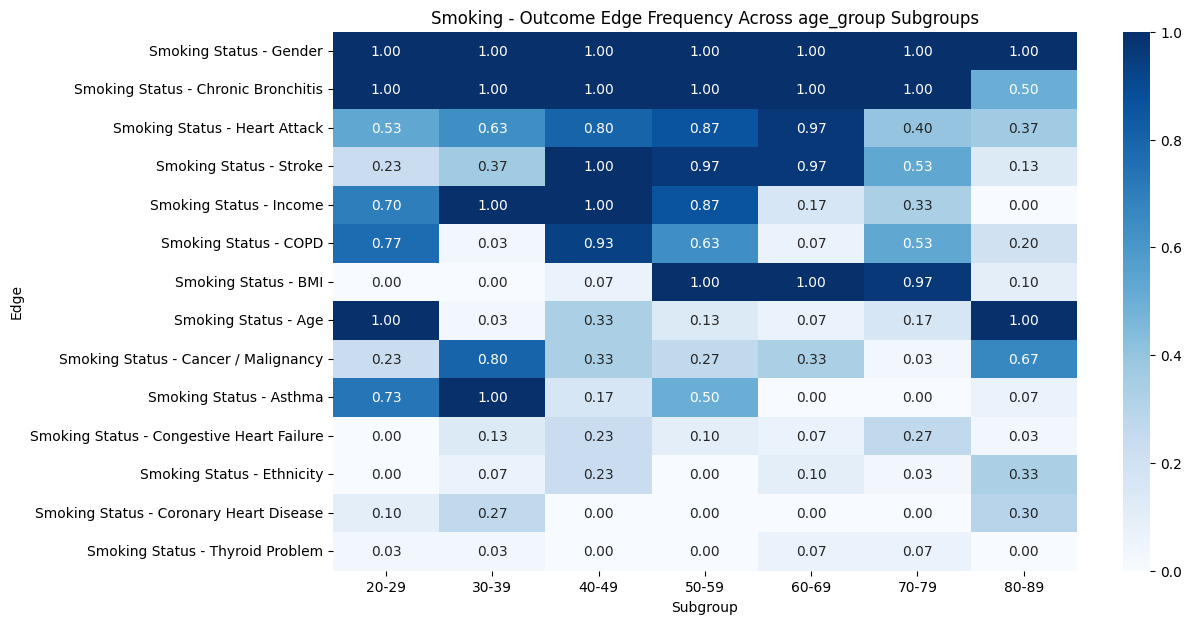

In [9]:
n_bootstraps = 30
alpha = 0.1
indep_test_type = "chi_square"
amat_baseline = A_base
age_bins = [10, 19, 29, 39, 49, 59, 69, 79, 89, 120]
age_labels = list(range(len(age_bins)-1))

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)
df['age_group'] = df['age_group'].astype(int)

encoding_maps['age_group'] = {i: i for i in df['age_group'].unique()}
demographic_col = 'age_group'
subgroup_results_age, _, = run_pc_subgroup_analysis(
    df=df,
    demographic_col=demographic_col,
    encoding_maps=encoding_maps,
    baseline_edge_freq=baseline_edge_freq,
    colnames=colnames,
    bk=bk,
    amat_baseline=amat_baseline,
    n_bootstraps=n_bootstraps,
    alpha=alpha,
    indep_test_type=indep_test_type,
    human_readable_map=human_readable_maps['age_group']
)



# Gender Demographic Analysis

In [11]:
demographic_col = "gender"
n_bootstraps = 30
alpha = 0.1
indep_test_type = "chi_square"
amat_baseline = A_base

subgroup_results_gender, _,  = run_pc_subgroup_analysis(
    df=df,
    demographic_col=demographic_col,
    encoding_maps=encoding_maps,
    baseline_edge_freq = baseline_edge_freq,
    colnames=colnames,
    bk=bk,
    amat_baseline=amat_baseline,
    n_bootstraps=n_bootstraps,
    alpha=alpha,
    indep_test_type=indep_test_type,
    human_readable_map=human_readable_maps['gender']
)


===== Running PC Subgroup Analysis for gender =====

Subgroup: 0 (gender)
Subgroup size: 12881 rows


Bootstraps (0):   0%|                                    | 0/30 [00:00<?, ?it/s]/opt/anaconda3/envs/causal-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/causal-env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):   3%|▉                           | 1/30 [00:08<04:00,  8.30s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):   7%|█▊                          | 2/30 [00:16<03:57,  8.48s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  10%|██▊                         | 3/30 [00:24<03:40,  8.18s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  13%|███▋                        | 4/30 [00:32<03:28,  8.04s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  17%|████▋                       | 5/30 [00:40<03:20,  8.04s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  20%|█████▌                      | 6/30 [00:48<03:14,  8.11s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  23%|██████▌                     | 7/30 [00:56<03:06,  8.11s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  27%|███████▍                    | 8/30 [01:05<03:02,  8.30s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  30%|████████▍                   | 9/30 [01:13<02:54,  8.29s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  33%|█████████                  | 10/30 [01:22<02:45,  8.26s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  37%|█████████▉                 | 11/30 [01:30<02:37,  8.30s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  40%|██████████▊                | 12/30 [01:38<02:27,  8.18s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  43%|███████████▋               | 13/30 [01:46<02:17,  8.09s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  47%|████████████▌              | 14/30 [01:54<02:08,  8.05s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  50%|█████████████▌             | 15/30 [02:01<01:59,  7.95s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  53%|██████████████▍            | 16/30 [02:10<01:52,  8.01s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  57%|███████████████▎           | 17/30 [02:18<01:44,  8.02s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  60%|████████████████▏          | 18/30 [02:26<01:36,  8.00s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  63%|█████████████████          | 19/30 [02:34<01:30,  8.23s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  67%|██████████████████         | 20/30 [02:43<01:24,  8.45s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  70%|██████████████████▉        | 21/30 [02:52<01:17,  8.62s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  73%|███████████████████▊       | 22/30 [03:01<01:08,  8.50s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  77%|████████████████████▋      | 23/30 [03:09<00:58,  8.41s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  80%|█████████████████████▌     | 24/30 [03:17<00:49,  8.32s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  83%|██████████████████████▌    | 25/30 [03:25<00:41,  8.28s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  87%|███████████████████████▍   | 26/30 [03:33<00:32,  8.22s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  90%|████████████████████████▎  | 27/30 [03:42<00:24,  8.27s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  93%|█████████████████████████▏ | 28/30 [03:50<00:16,  8.22s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0):  97%|██████████████████████████ | 29/30 [03:58<00:08,  8.37s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (0): 100%|███████████████████████████| 30/30 [04:07<00:00,  8.24s/it]


Subgroup 0 mean SHD: 4.13, median SHD: 4.00

Subgroup: 1 (gender)
Subgroup size: 13851 rows


Bootstraps (1):   0%|                                    | 0/30 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):   3%|▉                           | 1/30 [00:08<04:03,  8.39s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):   7%|█▊                          | 2/30 [00:17<04:00,  8.60s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  10%|██▊                         | 3/30 [00:25<03:55,  8.71s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  13%|███▋                        | 4/30 [00:34<03:39,  8.46s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  17%|████▋                       | 5/30 [00:42<03:31,  8.47s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  20%|█████▌                      | 6/30 [00:50<03:19,  8.31s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  23%|██████▌                     | 7/30 [00:58<03:11,  8.34s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  27%|███████▍                    | 8/30 [01:06<03:00,  8.20s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  30%|████████▍                   | 9/30 [01:15<02:53,  8.28s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  33%|█████████                  | 10/30 [01:23<02:44,  8.24s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  37%|█████████▉                 | 11/30 [01:31<02:37,  8.31s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  40%|██████████▊                | 12/30 [01:39<02:27,  8.18s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  43%|███████████▋               | 13/30 [01:48<02:19,  8.19s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  47%|████████████▌              | 14/30 [01:56<02:10,  8.14s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  50%|█████████████▌             | 15/30 [02:03<02:00,  8.06s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  53%|██████████████▍            | 16/30 [02:12<01:53,  8.08s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  57%|███████████████▎           | 17/30 [02:20<01:46,  8.20s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  60%|████████████████▏          | 18/30 [02:28<01:38,  8.24s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  63%|█████████████████          | 19/30 [02:36<01:30,  8.19s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  67%|██████████████████         | 20/30 [02:45<01:22,  8.22s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  70%|██████████████████▉        | 21/30 [02:53<01:14,  8.28s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  73%|███████████████████▊       | 22/30 [03:02<01:07,  8.49s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  77%|████████████████████▋      | 23/30 [03:10<00:58,  8.36s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  80%|█████████████████████▌     | 24/30 [03:18<00:49,  8.29s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  83%|██████████████████████▌    | 25/30 [03:26<00:41,  8.22s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  87%|███████████████████████▍   | 26/30 [03:35<00:32,  8.22s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  90%|████████████████████████▎  | 27/30 [03:43<00:24,  8.24s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  93%|█████████████████████████▏ | 28/30 [03:51<00:16,  8.24s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1):  97%|██████████████████████████ | 29/30 [03:59<00:08,  8.19s/it]

  0%|          | 0/16 [00:00<?, ?it/s]

Bootstraps (1): 100%|███████████████████████████| 30/30 [04:08<00:00,  8.29s/it]

Subgroup 1 mean SHD: 4.10, median SHD: 4.00


# Edge Stability Across All Subgroups and Demographics

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

edges_of_interest = [
    "BMI","MCQ160O","MCQ160K","MCQ160E","MCQ160C",
    "MCQ160B","MCQ160F","MCQ220","MCQ160M","MCQ010",
    "age","ethnicity","gender", "income"
]

friendly_labels = {
    "smoking_status": "Smoking Status",
    "BMI": "BMI",
    "MCQ160O": "COPD",
    "MCQ160K": "Chronic Bronchitis",
    "MCQ160E": "Heart Attack",
    "MCQ160C": "Coronary Heart Disease",
    "MCQ160B": "Congestive Heart Failure",
    "MCQ160F": "Stroke",
    "MCQ220": "Cancer / Malignancy",
    "MCQ160M": "Thyroid Problem",
    "MCQ010": "Asthma",
    "age": "Age",
    "ethnicity": "Ethnicity",
    "gender": "Gender",
    "income": "Income"
}

all_subgroup_results = {
    'age': subgroup_results_age,
    'ethnicity': subgroup_results_ethnicity,
    'gender': subgroup_results_gender
}

violin_rows = []


demographics = ["age", "ethnicity", "gender"]
violin_rows = []

for demo_name, subgroup_results in all_subgroup_results.items():
    for subgroup_name, results in subgroup_results.items():
        stab_df_sub = results["stab_df"]

        stab_df_sub = stab_df_sub[
            (stab_df_sub['var_i'] == "smoking_status") | (stab_df_sub['var_j'] == "smoking_status")
        ]
        stab_df_sub = stab_df_sub[
            stab_df_sub.apply(
                lambda row: (
                    (row['var_j'] if row['var_i']=="smoking_status" else row['var_i'])
                ) in edges_of_interest
                and (
                    (row['var_j'] if row['var_i']=="smoking_status" else row['var_i']) != demo_name
                ),
                axis=1
            )
        ]

        for _, row in stab_df_sub.iterrows():
            edge_label = f"{friendly_labels.get(row['var_i'], row['var_i'])} - {friendly_labels.get(row['var_j'], row['var_j'])}"
            violin_rows.append({
                "Edge": edge_label,
                "Edge_Freq": row["edge_freq"],
                "Subgroup": subgroup_name,
                "Demographic": friendly_labels.get(demo_name, demo_name)
            })

violin_df = pd.DataFrame(violin_rows)

edge_stats = violin_df.groupby(["Edge"])["Edge_Freq"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(12, 7))
plt.errorbar(
    x=edge_stats["mean"],        
    y=edge_stats["Edge"],    
    xerr=edge_stats["std"],  
    fmt="o",
    color="darkblue",
    ecolor="lightblue",
    capsize=5,
    markersize=8
)
plt.ylabel("Edge (Smoking - Outcomes)")
plt.xlabel("Mean Edge Frequency Across Subgroups ± Std Dev")
plt.title("Edge Stability Across All Subgroups and Demographics")
plt.tight_layout()
plt.show()

# Statistical Analysis

# Baseline Edge Frequency with 95% Confidence Interval
**Statistical analysis**: Compute edge frequency across all bootstrap replicates for each edge connecting smoking_status → outcome variables. Construct confidence intervals for the proportion of times each edge appears in bootstraps.

**MAJOR GOAL:** Find out which edges are stable or not stable in the baseline PC model. 


In [13]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

n_bootstraps = 30
stab_df_v1 = stab_df.copy()
stab_df_v1['n_bootstraps'] = n_bootstraps

ci_lower = []
ci_upper = []

for idx, row in stab_df_v1.iterrows():
    count = int(row['edge_freq'] * row['n_bootstraps'])
    n = row['n_bootstraps']
    lower, upper = proportion_confint(count, n, alpha=0.05, method='wilson')
    ci_lower.append(lower)
    ci_upper.append(upper)

stab_df_v1['CI_lower'] = ci_lower
stab_df_v1['CI_upper'] = ci_upper

stab_df_v1['Edge'] = stab_df_v1.apply(
    lambda row: f"{friendly_labels.get(row['var_i'], row['var_i'])} - {friendly_labels.get(row['var_j'], row['var_j'])}",
    axis=1
)

v1_table = stab_df_v1[['Edge', 'edge_freq', 'CI_lower', 'CI_upper']].sort_values('edge_freq', ascending=False)
print("Visualization 1: Baseline Edge Frequency with 95% Confidence Interval")
print(v1_table)


Visualization 1: Baseline Edge Frequency with 95% Confidence Interval
                                         Edge  edge_freq  CI_lower  CI_upper
1                     Smoking Status - Gender   1.000000  0.886487  1.000000
3                     Smoking Status - Income   1.000000  0.886487  1.000000
4                        Smoking Status - BMI   1.000000  0.886487  1.000000
6         Smoking Status - Chronic Bronchitis   1.000000  0.886487  1.000000
7               Smoking Status - Heart Attack   1.000000  0.886487  1.000000
10                    Smoking Status - Stroke   1.000000  0.886487  1.000000
13                    Smoking Status - Asthma   1.000000  0.886487  1.000000
5                       Smoking Status - COPD   0.966667  0.833296  0.994091
11       Smoking Status - Cancer / Malignancy   0.366667  0.218739  0.544864
0                        Smoking Status - Age   0.000000  0.000000  0.113513
2                  Smoking Status - Ethnicity   0.000000  0.000000  0.113513
8     

# Measuring Heterogeneity Within Subgroups

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal

n_bootstraps = 30

def compute_kruskal_for_demographic(subgroup_results, demographic_name, edge_connector='-'):
    all_edges = set()
    for group, result in subgroup_results.items():
        df_edges = result['stab_df']
        for _, row in df_edges.iterrows():
            edge = f"{row['var_i']}{edge_connector}{row['var_j']}"
            all_edges.add(edge)

    kruskal_rows = []

    for edge in all_edges:
        subgroup_arrays = []
        for group, result in subgroup_results.items():
            df_edges = result['stab_df']
            var_i, var_j = edge.split(edge_connector)
            match = df_edges[
                ((df_edges['var_i'] == var_i) & (df_edges['var_j'] == var_j)) |
                ((df_edges['var_i'] == var_j) & (df_edges['var_j'] == var_i))
            ]
            if len(match) > 0:
                count = int(match['edge_freq'].values[0] * n_bootstraps)
                arr = np.concatenate([np.ones(count), np.zeros(n_bootstraps - count)])
            else:
                arr = np.zeros(n_bootstraps)
            subgroup_arrays.append(arr)

        if all(np.array_equal(subgroup_arrays[0], arr) for arr in subgroup_arrays[1:]):
            H_stat, p_value = np.nan, np.nan
        else:
            H_stat, p_value = kruskal(*subgroup_arrays)

        kruskal_rows.append({
            'Edge': edge,
            'Demographic': demographic_name,
            'H_stat': H_stat,
            'p_value': p_value
        })

    return pd.DataFrame(kruskal_rows)

kruskal_age = compute_kruskal_for_demographic(subgroup_results_age, 'Age')
kruskal_eth = compute_kruskal_for_demographic(subgroup_results_ethnicity, 'Ethnicity')
kruskal_gender = compute_kruskal_for_demographic(subgroup_results_gender, 'Gender')
kruskal_results = pd.concat([kruskal_age, kruskal_eth, kruskal_gender], ignore_index=True)
kruskal_results = kruskal_results.sort_values('p_value')
kruskal_results.groupby(["Edge", "Demographic"]).mean("p_value")

H_stat       p_value
Edge                     Demographic                          
smoking_status-BMI       Age          186.727623  1.262530e-37
                         Ethnicity    106.393791  4.274214e-22
                         Gender        39.333333  3.572895e-10
smoking_status-MCQ010    Age          124.394873  1.943006e-24
                         Ethnicity     25.736364  3.576343e-05
                         Gender        18.160055  2.030943e-05
smoking_status-MCQ160B   Age           16.991135  9.315879e-03
                         Ethnicity      3.571918  4.670277e-01
                         Gender              NaN           NaN
smoking_status-MCQ160C   Age           37.290000  1.545886e-06
                         Ethnicity     12.331034  1.505211e-02
                         Gender         4.214286  4.008494e-02
smoking_status-MCQ160E   Age           42.966103  1.184590e-07
                         Ethnicity     88.882806  2.274028e-18
                         Gender         2.034483  1.537665e-01
smoking_status-MCQ160F   Age          104.500000  2.883206e-20
                         Ethnicity     94.688122  1.327635e-19
                         Gender              NaN           NaN
smoking_status-MCQ160K   Age           96.461538  1.371720e-18
                         Ethnicity     98.525745  2.026066e-20
                         Gender              NaN           NaN
smoking_status-MCQ160M   Age            5.805556  4.453208e-01
                         Ethnicity     17.028571  1.908398e-03
                         Gender         3.975741  4.616013e-02
smoking_status-MCQ160O   Age           91.290435  1.634247e-17
                         Ethnicity     34.900901  4.868247e-07
                         Gender         7.821604  5.162536e-03
smoking_status-MCQ220    Age           52.852885  1.256111e-09
                         Ethnicity     63.758598  4.698064e-13
                         Gender        23.325581  1.367688e-06
smoking_status-age       Age          137.355373  3.621650e-27
                         Ethnicity    118.751436  9.869966e-25
                         Gender        16.426136  5.058295e-05
smoking_status-ethnicity Age           29.739130  4.406066e-05
                         Ethnicity           NaN           NaN
                         Gender              NaN           NaN
smoking_status-gender    Age                 NaN           NaN
                         Ethnicity           NaN           NaN
                         Gender              NaN           NaN
smoking_status-income    Age          124.784836  1.608681e-24
                         Ethnicity     74.250836  2.869792e-15
                         Gender         4.214286  4.008494e-02

# Variation of Smoking - Outcome Edges Across Demographic Subgroups

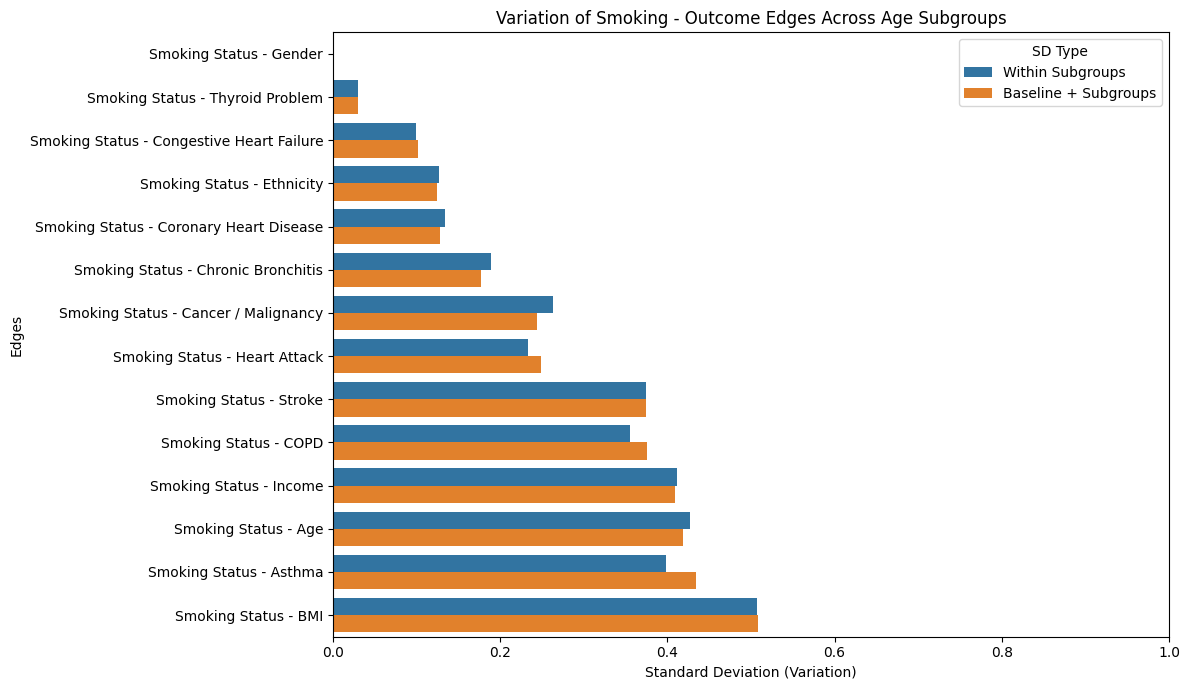

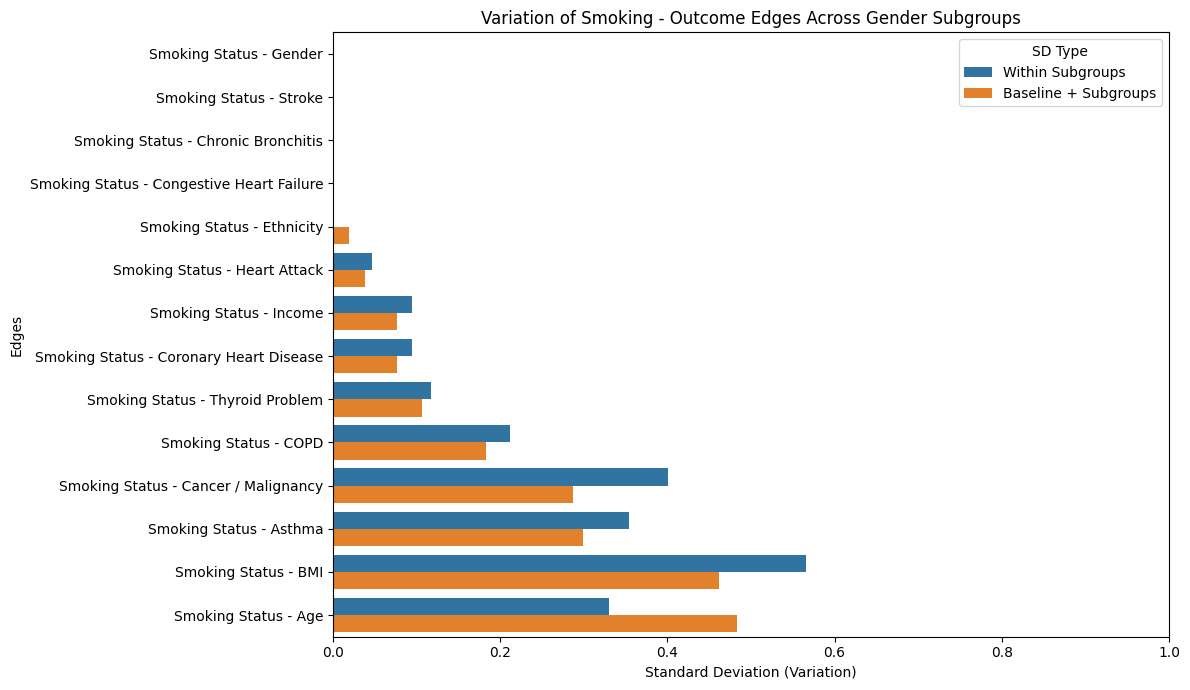

In [17]:
friendly_labels = {
    "smoking_status": "Smoking Status",
    "BMI": "BMI",
    "MCQ160O": "COPD",
    "MCQ160K": "Chronic Bronchitis",
    "MCQ160E": "Heart Attack",
    "MCQ160C": "Coronary Heart Disease",
    "MCQ160B": "Congestive Heart Failure",
    "MCQ160F": "Stroke",
    "MCQ220": "Cancer / Malignancy",
    "MCQ160M": "Thyroid Problem",
    "MCQ010": "Asthma",
    "age": "Age",
    "ethnicity": "Ethnicity",
    "gender": "Gender",
    "income": "Income"
}

def compute_variation_within_between(subgroup_results_dicts, baseline_edge_freq, edge_connector='-'):
    if isinstance(baseline_edge_freq, dict):
        baseline_edge_freq = pd.DataFrame({
            'Edge': list(baseline_edge_freq.keys()),
            'edge_freq': list(baseline_edge_freq.values())
        })
    
    if 'var_i' not in baseline_edge_freq.columns or 'var_j' not in baseline_edge_freq.columns:
        baseline_edge_freq[['var_i','var_j']] = baseline_edge_freq['Edge'].str.split(edge_connector, expand=True)
    
    rows = []
    
    for demo_name, subgroup_results in subgroup_results_dicts.items():
        all_edges = set()

        for group, result in subgroup_results.items():
            df_edges = result['stab_df']
            
            for _, row in df_edges.iterrows():
                edge = f"{row['var_i']}{edge_connector}{row['var_j']}"
                all_edges.add(edge)
        
        for edge in all_edges:
            var_i, var_j = edge.split(edge_connector)
            freqs = []
            for group, result in subgroup_results.items():
                df_edges = result['stab_df']
                match = df_edges[
                    ((df_edges['var_i']==var_i) & (df_edges['var_j']==var_j)) |
                    ((df_edges['var_i']==var_j) & (df_edges['var_j']==var_i))
                ]
                freqs.append(match['edge_freq'].values[0] if len(match) > 0 else 0.0)
            
            within_sd = np.std(freqs, ddof=1) if len(freqs) > 1 else 0.0
            baseline_match = baseline_edge_freq[
                ((baseline_edge_freq['var_i']==var_i) & (baseline_edge_freq['var_j']==var_j)) |
                ((baseline_edge_freq['var_i']==var_j) & (baseline_edge_freq['var_j']==var_i))
            ]
            baseline_freq = baseline_match['edge_freq'].values[0] if len(baseline_match) > 0 else 0.0
            
            freqs_with_baseline = freqs + [baseline_freq]
            baseline_plus_sd = np.std(freqs_with_baseline, ddof=1) if len(freqs_with_baseline) > 1 else 0.0
            edge_label_friendly = f"{friendly_labels.get(var_i,var_i)} - {friendly_labels.get(var_j,var_j)}"
            demo_label_friendly = friendly_labels.get(demo_name, demo_name)
            
            rows.append({
                'Edge': edge_label_friendly,
                'Demographic': demo_label_friendly,
                'Within Subgroups': within_sd,
                'Baseline + Subgroups': baseline_plus_sd
            })
    
    var_df = pd.DataFrame(rows)
    return var_df

var_df = compute_variation_within_between(subgroup_results_dicts, baseline_edge_freq, edge_connector='--')
custom_palette = {
    "Within Subgroups": "C0", 
    "Baseline + Subgroups": "C1"
}

for demo in var_df['Demographic'].unique():
    demo_df = var_df[var_df['Demographic'] == demo].sort_values('Baseline + Subgroups', ascending=True)
    demo_df_melted = demo_df.melt(
        id_vars=['Edge'],
        value_vars=['Within Subgroups', 'Baseline + Subgroups'],
        var_name='SD_Type',
        value_name='SD_Value'
    )
    plt.figure(figsize=(12, 7))
    sns.barplot(data=demo_df_melted, x='SD_Value', y='Edge', hue='SD_Type', palette=custom_palette)
    plt.title(f"Variation of Smoking - Outcome Edges Across {demo} Subgroups")
    plt.xlabel("Standard Deviation (Variation)")
    plt.ylabel("Edges")
    plt.legend(title='SD Type')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
